In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

In [ ]:
import pandas as pd
import re
import numpy as np
import itertools
import collections
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import string
from wordcloud import WordCloud

import nltk
nltk.download('treebank')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 

import gensim
from gensim.models import KeyedVectors, Word2Vec, FastText

import tensorflow as tf
import unicodedata

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
train_df = pd.read_csv("Mal_sentiment_train.tsv", sep='\t')
print(len(train_df))

valid_df = pd.read_csv("Mal_sentiment_dev.tsv", sep='\t')
print(len(valid_df))

test_df = pd.read_csv("Mal_sentiment_test_withoutlabels.tsv", sep='\t')
len(test_df)

15888
1766


1962

In [ ]:
test_df

,id,text
0,Mal_1,Teaserinu kurach samayamkoodi mathram. Cant wa...
1,Mal_2,അപ്പോൾ കഥയുടെ റൂട്ട് മാറിയല്ലോ...
2,Mal_3,മൂത്തോൻ ട്രൈലെർ Trending List വരാത്തത് എന്താ ?
3,Mal_4,Nowadays 944k views is considered as 1M views ...
4,Mal_5,Maass.trailer ennu paranja ithaanU makkale.......
...,...,...
1957,Mal_1958,Expression വച്ചു നോക്കുമ്പോൾ മൂക്കുത്തി കട്ടത്...
1958,Mal_1959,എനിക്ക് ഒരു 100 like തരുമോ
1959,Mal_1960,Nannayi onnu poliyunna lakshnm unde...Thrill m...
1960,Mal_1961,Athikam eduthu kayatti vekkenda....direction k...


In [ ]:
print(test_df['text'][279])
print(test_df['text'][516])
print(test_df['text'][546])
print(test_df['text'][555])
print(test_df['text'][559])
print(test_df['text'][570])

Oru pani-palal manakunnu again Mr. JR :/
Ende ponno 68 vayasaya oraluda body thanneyano ith.... 🤩.. NAMICHU PONNIKKAAAA
FDFS.. trailer kandu ithu vareyum njanithu paranjittilla..🤩🤩
Degraders step BacK 🤫...  മമ്മൂക്ക
ഈ പാട്ട് ഡിസ്‌ലൈക് ചെയ്തവരുടെ വീട്ടുകാരെ സമ്മതിക്കണം .....BIG SALUTE
ഇത് ഏത് ഭാഷ ശിവനെ ഏത് ജില്ല 🤔🤔🤔🤔🤔🤔🤔


In [ ]:
train_df['text'][0]

'Sunny chechi fans evide like adichu power kaniku🤣🤣'

In [ ]:
train_df

,text,category
0,Sunny chechi fans evide like adichu power kani...,unknown_state
1,Angane july month ile ende aadyathe leave njan...,Positive
2,ഏട്ടന്റെ പുതിയ പടത്തിനു വേണ്ടി കാത്തിരിക്കുന്ന...,unknown_state
3,ഇനി ലാലേട്ടന്റെ വേട്ട തുടങ്ങാൻ പോകുന്നു..........,Positive
4,Trailer powli oru raksha illa . Pakshea padam ...,Positive
...,...,...
15883,Minimum 10 thavana kandavar maathram like adi,unknown_state
15884,Please cinema kaannaaan kothi aakunnu onnu rel...,Positive
15885,USA ok.. India No... Sadhacharam,unknown_state
15886,nama hero december 12 wait & see mamamaga mah...,Positive


In [ ]:
train_df['category'].value_counts()

Positive          6421
unknown_state     5279
Negative          2105
not-malayalam     1157
Mixed_feelings     926
Name: category, dtype: int64

In [ ]:
valid_df['category'].value_counts()

Positive          706
unknown_state     580
Negative          237
not-malayalam     141
Mixed_feelings    102
Name: category, dtype: int64

In [ ]:
valid_df

,text,category
0,Mammooka ninghal mass aa pwoli item,Positive
1,Waiting for Malayalam movie For Tamil paiyan,not-malayalam
2,ദളപതി ഫാൻസിന്റെ വക ഒരു ഒന്നൊന്നര വിജയാശംസകൾ...,Positive
3,#Trailer pwolichuuuu ഓണത്തിന് വന്നങ്ങു തകർത്തേ...,Positive
4,Mammoookkaaaa polichadukkiii katta waiting nv 21,Positive
...,...,...
1761,Aa ചിരി uff എന്റെ പൊന്നോ ഇക്ക vere ലെവൽ,Positive
1762,Katta katta katta katta waiting....cant wait man,Positive
1763,Arjun reddy bgm poole thonniyathu enniku mathr...,unknown_state
1764,Fahad ikka ithilum polikum en urappayi,Positive


In [ ]:
valid_df['text']

0                     Mammooka ninghal mass aa pwoli item
1           Waiting for Malayalam movie  For Tamil paiyan
2          ദളപതി ഫാൻസിന്റെ വക ഒരു ഒന്നൊന്നര വിജയാശംസകൾ...
3       #Trailer pwolichuuuu ഓണത്തിന് വന്നങ്ങു തകർത്തേ...
4        Mammoookkaaaa polichadukkiii katta waiting nv 21
                              ...                        
1761              Aa ചിരി uff എന്റെ പൊന്നോ ഇക്ക vere ലെവൽ
1762     Katta katta katta katta waiting....cant wait man
1763    Arjun reddy bgm poole thonniyathu enniku mathr...
1764               Fahad ikka ithilum polikum en urappayi
1765    Njan veendum kanan vannu 100 pravashyam enkilu...
Name: text, Length: 1766, dtype: object

In [ ]:
len(train_df)

15888

In [ ]:
for i in range(len(train_df)):
  if (train_df['category'][i] == 'Positive '):
    print(i)

In [ ]:
train_df['category'][1586]

'Negative'

In [ ]:
train_df['category'][1586] = 'Positive'
train_df['category'][1586]

'Positive'

In [ ]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)


for i in range(len(train_df)):
    temp1 = deEmojify(train_df['text'][i])
    train_df['text'][i] = temp1

for j in range(len(valid_df)):
    temp2 = deEmojify(valid_df['text'][j])
    valid_df['text'][j] = temp2

for k in range(len(test_df)):
    temp3 = deEmojify(test_df['text'][k])
    test_df['text'][k]=temp3

In [ ]:
print(test_df['text'][516])
print(test_df['text'][546])
print(test_df['text'][555])
print(test_df['text'][559])
print(test_df['text'][570])

Ende ponno 68 vayasaya oraluda body thanneyano ith.... .. NAMICHU PONNIKKAAAA
FDFS.. trailer kandu ithu vareyum njanithu paranjittilla..
Degraders step BacK ...  മമ്മൂക്ക
ഈ പാട്ട് ഡിസ്‌ലൈക് ചെയ്തവരുടെ വീട്ടുകാരെ സമ്മതിക്കണം .....BIG SALUTE
ഇത് ഏത് ഭാഷ ശിവനെ ഏത് ജില്ല 


In [ ]:
def preprocess_data(text):
  user_name = '@[A-Za-z0-9]+' # Pattern for matching the user names in the tweet
  has_tag = '#[A-Za-z0-9]+' # Pattern for matching the hasgtags in the tweet
  url = 'https?:\/\/[A-Za-z0-9\.\/\-]+' # Pattern for matching the URLs in the tweet
  #emoji_pattern = r'/[x{1F600}-x{1F64F}]/u'
  
  x = text.lower()  # Lower casing all the characters
  x = re.sub(user_name, '', x) # Replace the username with an empty characrer
  x = re.sub(has_tag,'',x) # Replace the hashtags with an empty characrer
  x = re.sub(url, '', x) # Replace the URLs with an empty characrer
  #x = re.sub(emoji_pattern, '', x)
  x = x.translate(str.maketrans('', '', string.punctuation)) # Replace all the characters except alphabets and digits from the tweet

  return x

In [ ]:
train_df['text'] = train_df['text'].apply(lambda x: preprocess_data(x)) # Apply the clean_data() to all the entries in the dataframe
valid_df['text'] = valid_df['text'].apply(lambda x: preprocess_data(x)) # Apply the clean_data() to all the entries in the dataframe
test_df['text'] = test_df['text'].apply(lambda x: preprocess_data(x)) # Apply the clean_data() to all the entries in the dataframe

In [ ]:
print(test_df['text'][279])
print(test_df['text'][516])
print(test_df['text'][546])
print(test_df['text'][555])
print(test_df['text'][559])
print(test_df['text'][570])

oru panipalal manakunnu again mr jr 
ende ponno 68 vayasaya oraluda body thanneyano ith  namichu ponnikkaaaa
fdfs trailer kandu ithu vareyum njanithu paranjittilla
degraders step back   മമ്മൂക്ക
ഈ പാട്ട് ഡിസ്‌ലൈക് ചെയ്തവരുടെ വീട്ടുകാരെ സമ്മതിക്കണം big salute
ഇത് ഏത് ഭാഷ ശിവനെ ഏത് ജില്ല 


In [ ]:
valid_df['text'][0]

'mammooka ninghal mass aa pwoli item'

In [ ]:
print(train_df)
print()
#print(valid_df.head())
#print()
print(valid_df)
print()
print(test_df)

                                                    text        category
0       sunny chechi fans evide like adichu power kaniku   unknown_state
1      angane july month ile ende aadyathe leave njan...        Positive
2      ഏട്ടന്റെ പുതിയ പടത്തിനു വേണ്ടി കാത്തിരിക്കുന്ന...   unknown_state
3      ഇനി ലാലേട്ടന്റെ വേട്ട തുടങ്ങാൻ പോകുന്നു മുൻ കാ...        Positive
4      trailer powli oru raksha illa  pakshea padam i...        Positive
...                                                  ...             ...
15883      minimum 10 thavana kandavar maathram like adi   unknown_state
15884  please cinema kaannaaan kothi aakunnu onnu rel...        Positive
15885                        usa ok india no sadhacharam   unknown_state
15886  nama hero december 12 wait  see  mamamaga maha...        Positive
15887  madhuraraja 1 hour 40 k likes  lucifer 1 min 4...  Mixed_feelings

[15888 rows x 2 columns]

                                                   text       category
0                   mammoo

In [ ]:
train_text = train_df['text'].tolist()
valid_text = valid_df['text'].tolist()
test_text = test_df['text'].tolist()

train_label = train_df['category'].tolist()
valid_label = valid_df['category'].tolist()

In [ ]:
test_text

['teaserinu kurach samayamkoodi mathram cant wait',
 'അപ്പോൾ കഥയുടെ  റൂട്ട് മാറിയല്ലോ',
 'മൂത്തോൻ ട്രൈലെർ trending list വരാത്തത് എന്താ ',
 'nowadays 944k views is considered as 1m views in kerala',
 'maasstrailer ennu paranja ithaanu makkalekatta waiting for ',
 'ethu kandappol kgf orma vannathu enikku matram ano ',
 'vere level  onnum parayan ella',
 'idvere vere chilar parannadaaannn muruga nee theernnada ennn ini nangal mammookka fans sherikkum parayunnnu murugaaa nee theernnada ikka love',
 'റിലീസ് ചെയ്ത അന്ന് തന്നെ പടം കാണാൻ ബോണി പറഞ്ഞു',
 'lalettanu thulayam malayalam film industry yil latten mathram',
 'chankurappulla ikka fans vaa 21 nu charithram kurikkum',
 'മലയാളത്തിലെ ഏറ്റവും മാസ്സ് കഥാപാത്രം ആയിരിക്കും ഇത്',
 'പാടുമ്പോൾ ഹിന്ദിക്കാരി ആയ പാവം ആ ശ്രേയ വല്ലോം അറിഞ്ഞോ ഈ പാട്ടിന്റെ ഗതി കഷ്ടം',
 'മമ്മൂക്കയെ കാണാത്തതുകൊണ്ട് ആരും വിഷമിക്കേണ്ട മമ്മൂക്ക മൂക്കുത്തി കണ്ടു പിടിക്കാൻ പോയിരിക്കുകയാണ് കണ്ടു പിടിച്ച ഉടനെ വരുന്നതായിരിക്കും',
 'ഉണ്ണി മുകുന്ദന്റെ നോട്ടം കണ്ടാലറിയ മൂക്കുത്തി എട

In [ ]:
class_names = list(set(train_label))
class_names

['Negative', 'Positive', 'not-malayalam', 'unknown_state', 'Mixed_feelings']

In [ ]:
len(train_label)

15888

In [ ]:
class_dist = Counter(train_label)
class_dist

Counter({'unknown_state': 5279,
         'Positive': 6422,
         'Negative': 2104,
         'Mixed_feelings': 926,
         'not-malayalam': 1157})

In [ ]:
class_dist = Counter(valid_label)
class_dist

Counter({'Positive': 706,
         'not-malayalam': 141,
         'unknown_state': 580,
         'Negative': 237,
         'Mixed_feelings': 102})

In [ ]:
le = LabelEncoder()

train_label = le.fit_transform(train_label)
train_label

array([4, 2, 4, ..., 4, 2, 0])

In [ ]:
valid_label = le.fit_transform(valid_label)
valid_label

array([2, 3, 2, ..., 4, 2, 2])

In [ ]:
le.inverse_transform([0,1,2,3,4])

array(['Mixed_feelings', 'Negative', 'Positive', 'not-malayalam',
       'unknown_state'], dtype='<U14')

In [ ]:
class_weight = {0:sum(class_dist.values())/class_dist[le.inverse_transform([0])[0]],
                1:sum(class_dist.values())/class_dist[le.inverse_transform([1])[0]],
                2:sum(class_dist.values())/class_dist[le.inverse_transform([2])[0]],
                3:sum(class_dist.values())/class_dist[le.inverse_transform([3])[0]],
                4:sum(class_dist.values())/class_dist[le.inverse_transform([4])[0]]}

class_weight

{0: 17.313725490196077,
 1: 7.451476793248945,
 2: 2.501416430594901,
 3: 12.52482269503546,
 4: 3.0448275862068965}

In [ ]:
training_labels = tf.keras.utils.to_categorical(train_label)
validation_labels = tf.keras.utils.to_categorical(valid_label)

In [ ]:
words_in_train = [sent.split() for sent in train_text] # Splitting the tweet into tokens
words_in_train[0:5]

[['sunny', 'chechi', 'fans', 'evide', 'like', 'adichu', 'power', 'kaniku'],
 ['angane',
  'july',
  'month',
  'ile',
  'ende',
  'aadyathe',
  'leave',
  'njan',
  'angu',
  'edukuva',
  'july',
  '5',
  'nu'],
 ['ഏട്ടന്റെ',
  'പുതിയ',
  'പടത്തിനു',
  'വേണ്ടി',
  'കാത്തിരിക്കുന്നവർ',
  'ലൈക്\u200c',
  'ബട്ടൺ',
  'അടിച്ചു',
  'പോളിക്കോ'],
 ['ഇനി',
  'ലാലേട്ടന്റെ',
  'വേട്ട',
  'തുടങ്ങാൻ',
  'പോകുന്നു',
  'മുൻ',
  'കാല',
  'collection',
  'recordukal',
  'ഭേതിച്ചിരിക്കും'],
 ['trailer',
  'powli',
  'oru',
  'raksha',
  'illa',
  'pakshea',
  'padam',
  'irangattea',
  'veruthea',
  'over',
  'degrade',
  'venda',
  'padam',
  'irangittu',
  'paraya']]

In [ ]:
words_in_valid = [sent.split() for sent in valid_text] # Splitting the tweet into tokens
words_in_valid[0:5]

[['mammooka', 'ninghal', 'mass', 'aa', 'pwoli', 'item'],
 ['waiting', 'for', 'malayalam', 'movie', 'for', 'tamil', 'paiyan'],
 ['ദളപതി', 'ഫാൻസിന്റെ', 'വക', 'ഒരു', 'ഒന്നൊന്നര', 'വിജയാശംസകൾ'],
 ['pwolichuuuu', 'ഓണത്തിന്', 'വന്നങ്ങു', 'തകർത്തേക്ക്'],
 ['mammoookkaaaa', 'polichadukkiii', 'katta', 'waiting', 'nv', '21']]

In [ ]:
words_in_test = [sent.split() for sent in test_text] # Splitting the tweet into tokens
words_in_test[0:5]

[['teaserinu', 'kurach', 'samayamkoodi', 'mathram', 'cant', 'wait'],
 ['അപ്പോൾ', 'കഥയുടെ', 'റൂട്ട്', 'മാറിയല്ലോ'],
 ['മൂത്തോൻ', 'ട്രൈലെർ', 'trending', 'list', 'വരാത്തത്', 'എന്താ'],
 ['nowadays',
  '944k',
  'views',
  'is',
  'considered',
  'as',
  '1m',
  'views',
  'in',
  'kerala'],
 ['maasstrailer',
  'ennu',
  'paranja',
  'ithaanu',
  'makkalekatta',
  'waiting',
  'for']]

In [ ]:
all_words_train = list(itertools.chain(*words_in_train)) # Making a flatlist of all the words in the corpus
all_words_train[0:10]

['sunny',
 'chechi',
 'fans',
 'evide',
 'like',
 'adichu',
 'power',
 'kaniku',
 'angane',
 'july']

In [ ]:
all_words_valid = list(itertools.chain(*words_in_valid)) # Making a flatlist of all the words in the corpus
all_words_valid[0:10]

['mammooka',
 'ninghal',
 'mass',
 'aa',
 'pwoli',
 'item',
 'waiting',
 'for',
 'malayalam',
 'movie']

In [ ]:
all_words_test = list(itertools.chain(*words_in_test)) # Making a flatlist of all the words in the corpus
all_words_test[0:10]

['teaserinu',
 'kurach',
 'samayamkoodi',
 'mathram',
 'cant',
 'wait',
 'അപ്പോൾ',
 'കഥയുടെ',
 'റൂട്ട്',
 'മാറിയല്ലോ']

In [ ]:
word_counts_train = collections.Counter(all_words_train)  # Computing the number of occurrence of all the words in the corpus
word_counts_train.most_common(15)

[('like', 1591),
 ('oru', 1415),
 ('ഒരു', 1378),
 ('trailer', 1179),
 ('ഈ', 1032),
 ('padam', 778),
 ('fans', 686),
 ('ee', 602),
 ('പടം', 598),
 ('ikka', 580),
 ('ഇത്', 515),
 ('mass', 513),
 ('movie', 453),
 ('ആണ്', 447),
 ('waiting', 447)]

In [ ]:
word_counts_valid = collections.Counter(all_words_valid)  # Computing the number of occurrence of all the words in the corpus
word_counts_valid.most_common(15)

[('ഒരു', 187),
 ('like', 166),
 ('oru', 165),
 ('ഈ', 125),
 ('trailer', 108),
 ('മൂക്കുത്തി', 90),
 ('ikka', 76),
 ('padam', 67),
 ('ee', 64),
 ('fans', 64),
 ('പടം', 63),
 ('movie', 60),
 ('waiting', 55),
 ('ഇത്', 54),
 ('mass', 48)]

In [ ]:
word_counts_valid = collections.Counter(all_words_test)  # Computing the number of occurrence of all the words in the corpus
word_counts_valid.most_common(15)

[('ഒരു', 205),
 ('like', 202),
 ('oru', 181),
 ('trailer', 152),
 ('ഈ', 121),
 ('padam', 99),
 ('ikka', 84),
 ('fans', 80),
 ('movie', 74),
 ('ee', 70),
 ('മൂക്കുത്തി', 62),
 ('mass', 62),
 ('പടം', 61),
 ('എന്ന്', 61),
 ('ആണ്', 61)]

In [ ]:
words_with_counts_train = pd.DataFrame(word_counts_train.most_common(len(all_words_train)), columns=['words', 'count']) 
print(words_with_counts_train.head())

     words  count
0     like   1591
1      oru   1415
2      ഒരു   1378
3  trailer   1179
4        ഈ   1032


In [ ]:
words_with_counts_valid = pd.DataFrame(word_counts_valid.most_common(len(all_words_valid)), columns=['words', 'count']) 
print(words_with_counts_valid.head())

     words  count
0      ഒരു    205
1     like    202
2      oru    181
3  trailer    152
4        ഈ    121


In [ ]:
words_with_counts_test = pd.DataFrame(word_counts_valid.most_common(len(all_words_valid)), columns=['words', 'count']) 
print(words_with_counts_valid.head())

     words  count
0      ഒരു    205
1     like    202
2      oru    181
3  trailer    152
4        ഈ    121


In [ ]:
all_words = all_words_train + all_words_valid + all_words_test
corpus = train_text + valid_text + test_text
vocab_size = len(set(all_words)) # number of words to keep.
embedding_dim = 100 # Dimension of the vector representation for each word 
max_length = 0
for i in range(len(corpus)):
  x = word_tokenize(corpus[i])
  if len(x) > max_length:
    max_length = len(x)

oov_tok = "<OOV>"

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index

In [ ]:
training_sequences = tokenizer.texts_to_sequences(train_text)
training_padded = tf.keras.preprocessing.sequence.pad_sequences(training_sequences,maxlen=max_length, padding='post')

valid_sequences = tokenizer.texts_to_sequences(valid_text)
valid_padded = tf.keras.preprocessing.sequence.pad_sequences(valid_sequences,maxlen=max_length, padding='post')


test_sequences = tokenizer.texts_to_sequences(test_text)
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences,maxlen=max_length, padding='post')

In [ ]:
METRICS = [
      #tf.keras.metrics.TruePositives(name='tp'),
      #tf.keras.metrics.FalsePositives(name='fp'),
      #tf.keras.metrics.TrueNegatives(name='tn'),
      #tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

In [ ]:
print(np.shape(training_padded))
print(np.shape(valid_padded))
print(np.shape(test_padded))

(15888, 229)
(1766, 229)
(1962, 229)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length,
                              embeddings_initializer='orthogonal', embeddings_regularizer='L2'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(5, activation=tf.nn.softmax)
])

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=METRICS
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 229, 100)          5122200   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               34048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 5,156,573
Trainable params: 5,156,573
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True)

num_epochs = 2
history = model.fit(
    training_padded,
    training_labels,
    epochs=num_epochs,
    batch_size = 256,
    callbacks=[callback],
    validation_data=(valid_padded, validation_labels),
    class_weight=class_weight
)

Epoch 1/2
63/63 [==============================] - 65s 846ms/step - loss: 8.5614 - accuracy: 0.8124 - precision: 0.6689 - recall: 0.1230 - auc: 0.7429 - val_loss: 5.3074 - val_accuracy: 0.8318 - val_precision: 0.6767 - val_recall: 0.3046 - val_auc: 0.7955
Epoch 2/2
63/63 [==============================] - 54s 852ms/step - loss: 10.3869 - accuracy: 0.8396 - precision: 0.6812 - recall: 0.3717 - auc: 0.8297 - val_loss: 6.4483 - val_accuracy: 0.8288 - val_precision: 0.6291 - val_recall: 0.3505 - val_auc: 0.8018


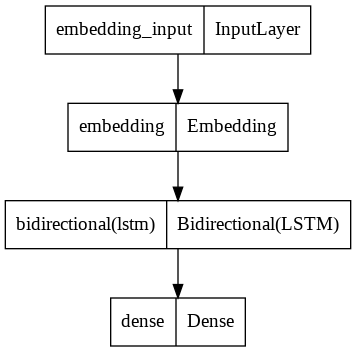

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

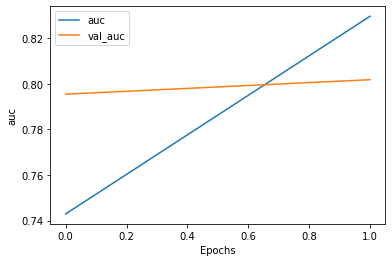

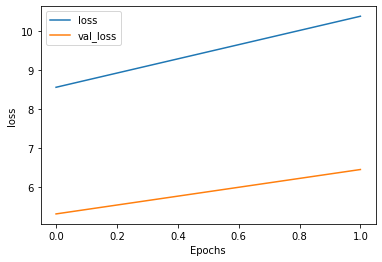

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "auc")
plot_graphs(history, "loss")

In [ ]:
score = model.evaluate(valid_padded, validation_labels)
print("Loss = {}".format(score[0]))
print("Accuracy = {0:.2f}%".format(score[1]*100))
print(score)

56/56 [==============================] - 3s 49ms/step - loss: 6.4483 - accuracy: 0.8288 - precision: 0.6291 - recall: 0.3505 - auc: 0.8018
Loss = 6.448268890380859
Accuracy = 82.88%
[6.448268890380859, 0.8287655711174011, 0.6290650367736816, 0.3505096137523651, 0.801814079284668]


In [ ]:
y_pred = np.argmax(model.predict(valid_padded), axis=-1)
classes_y = np.argmax(y_pred,axis=-1)
accuracy = accuracy_score(valid_label, y_pred)
precision = precision_score(valid_label, y_pred, average='macro')
recall = recall_score(valid_label, y_pred, average='macro')
f1 = f1_score(valid_label, y_pred, average='macro')

print("Accuracy = {0:.2f}".format(accuracy*100))
print("Precision = {0:.4f}".format(precision))
print("Recall = {0:.4f}".format(recall))
print("F1-score = {0:.4f}".format(f1))

56/56 [==============================] - 3s 40ms/step
Accuracy = 51.08
Precision = 0.5176
Recall = 0.6017
F1-score = 0.4958


In [ ]:
confusion_matrix(valid_label,y_pred)

array([[ 63,  19,  12,   1,   7],
       [ 36, 168,  11,   6,  16],
       [135, 126, 335,  60,  50],
       [ 12,   3,   4, 117,   5],
       [100, 163,  52,  46, 219]])

In [ ]:
print(classification_report(valid_label,y_pred))

              precision    recall  f1-score   support

           0       0.18      0.62      0.28       102
           1       0.35      0.71      0.47       237
           2       0.81      0.47      0.60       706
           3       0.51      0.83      0.63       141
           4       0.74      0.38      0.50       580

    accuracy                           0.51      1766
   macro avg       0.52      0.60      0.50      1766
weighted avg       0.66      0.51      0.53      1766



In [ ]:
def predict_review(model, reviews):
  # Create the sequences
  padding_type='post'
  sample_sequences = tokenizer.texts_to_sequences(reviews)
  reviews_padded = tf.keras.preprocessing.sequence.pad_sequences(sample_sequences, padding=padding_type, 
                                 maxlen=max_length) 
  class_pred = np.argmax(model.predict(reviews_padded), axis=-1)
  classes = np.argmax(class_pred,axis=-1)
  classes_prob = model.predict(reviews_padded)
  for x in range(len(reviews_padded)):
    print(reviews[x])
    print(le.inverse_transform([class_pred[x]]))
    print(classes_prob[x])
    print('\n')

In [ ]:
sample_test = test_text[0:10]
sample_test

['teaserinu kurach samayamkoodi mathram cant wait',
 'അപ്പോൾ കഥയുടെ  റൂട്ട് മാറിയല്ലോ',
 'മൂത്തോൻ ട്രൈലെർ trending list വരാത്തത് എന്താ ',
 'nowadays 944k views is considered as 1m views in kerala',
 'maasstrailer ennu paranja ithaanu makkalekatta waiting for ',
 'ethu kandappol kgf orma vannathu enikku matram ano ',
 'vere level  onnum parayan ella',
 'idvere vere chilar parannadaaannn muruga nee theernnada ennn ini nangal mammookka fans sherikkum parayunnnu murugaaa nee theernnada ikka love',
 'റിലീസ് ചെയ്ത അന്ന് തന്നെ പടം കാണാൻ ബോണി പറഞ്ഞു',
 'lalettanu thulayam malayalam film industry yil latten mathram']

In [ ]:
predict_review(model, sample_test)

1/1 [==============================] - 0s 39ms/step
teaserinu kurach samayamkoodi mathram cant wait
['not-malayalam']
[0.10153306 0.10075743 0.13726714 0.4779511  0.18249121]


അപ്പോൾ കഥയുടെ  റൂട്ട് മാറിയല്ലോ
['unknown_state']
[0.21891516 0.1749526  0.18689774 0.16524187 0.25399262]


മൂത്തോൻ ട്രൈലെർ trending list വരാത്തത് എന്താ 
['Mixed_feelings']
[0.2911792  0.18809055 0.26682582 0.14802612 0.10587818]


nowadays 944k views is considered as 1m views in kerala
['not-malayalam']
[0.00483336 0.004517   0.01153673 0.965251   0.01386186]


maasstrailer ennu paranja ithaanu makkalekatta waiting for 
['Positive']
[0.08939597 0.01874768 0.5895475  0.24994904 0.05235976]


ethu kandappol kgf orma vannathu enikku matram ano 
['Mixed_feelings']
[0.72201765 0.1243493  0.08196655 0.00870149 0.06296505]


vere level  onnum parayan ella
['Positive']
[0.17698492 0.12956251 0.64776534 0.00639669 0.03929038]


idvere vere chilar parannadaaannn muruga nee theernnada ennn ini nangal mammookka fans sheri

In [ ]:
class_pred = np.argmax(model.predict(test_padded), axis=-1)
classes = np.argmax(class_pred,axis=-1)
pred = []

for i in range(len(class_pred)):
  pred.append(le.inverse_transform([class_pred[i]])[0])

62/62 [==============================] - 3s 42ms/step


In [ ]:
pred_df = pd.DataFrame(pred, columns=['label'])
pred_df.head()

,label
0,not-malayalam
1,unknown_state
2,Mixed_feelings
3,not-malayalam
4,Positive


In [ ]:
result = pd.concat([test_df, pred_df], axis=1)
result.head()

,id,text,label
0,Mal_1,teaserinu kurach samayamkoodi mathram cant wait,not-malayalam
1,Mal_2,അപ്പോൾ കഥയുടെ റൂട്ട് മാറിയല്ലോ,unknown_state
2,Mal_3,മൂത്തോൻ ട്രൈലെർ trending list വരാത്തത് എന്താ,Mixed_feelings
3,Mal_4,nowadays 944k views is considered as 1m views ...,not-malayalam
4,Mal_5,maasstrailer ennu paranja ithaanu makkalekatta...,Positive


In [ ]:
result.to_csv('Task Masters_malayalam_task_A.tsv', sep = ',', index=False)

In [ ]:
class_pred = np.argmax(model.predict(test_padded), axis=-1)
classes = np.argmax(class_pred,axis=-1)
Valid_pred = []

for i in range(len(class_pred)):
    Valid_pred.append(le.inverse_transform([class_pred[i]])[0])

62/62 [==============================] - 3s 41ms/step


In [ ]:
class_pred.shape

(1962,)

In [ ]:
Valid_pred_df = pd.DataFrame(Valid_pred, columns=['Predicted label'])
Valid_pred_df.head()

,Predicted label
0,not-malayalam
1,unknown_state
2,Mixed_feelings
3,not-malayalam
4,Positive


In [ ]:
Valid_result = pd.concat([valid_df, Valid_pred_df], axis=1)
Valid_result

,text,category,Predicted label
0,mammooka ninghal mass aa pwoli item,Positive,not-malayalam
1,waiting for malayalam movie for tamil paiyan,not-malayalam,unknown_state
2,ദളപതി ഫാൻസിന്റെ വക ഒരു ഒന്നൊന്നര വിജയാശംസകൾ,Positive,Mixed_feelings
3,pwolichuuuu ഓണത്തിന് വന്നങ്ങു തകർത്തേക്ക്,Positive,not-malayalam
4,mammoookkaaaa polichadukkiii katta waiting nv 21,Positive,Positive
...,...,...,...
1957,NaN,NaN,Negative
1958,NaN,NaN,unknown_state
1959,NaN,NaN,Negative
1960,NaN,NaN,Negative


In [ ]:
Valid_result.to_csv('Task Masters_malayalam_task_A.tsv', sep = ',', index=False)

In [ ]:
valid_df

,text,category
0,mammooka ninghal mass aa pwoli item,Positive
1,waiting for malayalam movie for tamil paiyan,not-malayalam
2,ദളപതി ഫാൻസിന്റെ വക ഒരു ഒന്നൊന്നര വിജയാശംസകൾ,Positive
3,pwolichuuuu ഓണത്തിന് വന്നങ്ങു തകർത്തേക്ക്,Positive
4,mammoookkaaaa polichadukkiii katta waiting nv 21,Positive
...,...,...
1761,aa ചിരി uff എന്റെ പൊന്നോ ഇക്ക vere ലെവൽ,Positive
1762,katta katta katta katta waitingcant wait man,Positive
1763,arjun reddy bgm poole thonniyathu enniku mathr...,unknown_state
1764,fahad ikka ithilum polikum en urappayi,Positive


In [ ]:
d = pd.read_csv("Task Masters_malayalam_task_A.tsv", sep=',')
d

,text,category,Predicted label
0,mammooka ninghal mass aa pwoli item,Positive,not-malayalam
1,waiting for malayalam movie for tamil paiyan,not-malayalam,unknown_state
2,ദളപതി ഫാൻസിന്റെ വക ഒരു ഒന്നൊന്നര വിജയാശംസകൾ,Positive,Mixed_feelings
3,pwolichuuuu ഓണത്തിന് വന്നങ്ങു തകർത്തേക്ക്,Positive,not-malayalam
4,mammoookkaaaa polichadukkiii katta waiting nv 21,Positive,Positive
...,...,...,...
1957,NaN,NaN,Negative
1958,NaN,NaN,unknown_state
1959,NaN,NaN,Negative
1960,NaN,NaN,Negative


In [ ]:
d1 = pd.read_csv("Task Masters_malayalam_task_A.tsv", sep=',')
d1

,text,category,Predicted label
0,mammooka ninghal mass aa pwoli item,Positive,not-malayalam
1,waiting for malayalam movie for tamil paiyan,not-malayalam,unknown_state
2,ദളപതി ഫാൻസിന്റെ വക ഒരു ഒന്നൊന്നര വിജയാശംസകൾ,Positive,Mixed_feelings
3,pwolichuuuu ഓണത്തിന് വന്നങ്ങു തകർത്തേക്ക്,Positive,not-malayalam
4,mammoookkaaaa polichadukkiii katta waiting nv 21,Positive,Positive
...,...,...,...
1957,NaN,NaN,Negative
1958,NaN,NaN,unknown_state
1959,NaN,NaN,Negative
1960,NaN,NaN,Negative


In [ ]:
test_df = pd.read_csv("Mal_sentiment_test_withlabels.tsv", sep='\t')
len(test_df)

1962

In [ ]:
test_df.head()

,id,text,category
0,Mal_1,Teaserinu kurach samayamkoodi mathram. Cant wa...,Positive
1,Mal_2,അപ്പോൾ കഥയുടെ റൂട്ട് മാറിയല്ലോ...,unknown_state
2,Mal_3,മൂത്തോൻ ട്രൈലെർ Trending List വരാത്തത് എന്താ ?,unknown_state
3,Mal_4,Nowadays 944k views is considered as 1M views ...,not-malayalam
4,Mal_5,Maass.trailer ennu paranja ithaanU makkale.......,Positive


In [ ]:
test_label = test_df['category'].tolist()
test_label = le.fit_transform(test_label)

In [ ]:
y_pred = np.argmax(model.predict(test_padded), axis=-1)
classes_y = np.argmax(y_pred,axis=-1)
accuracy = accuracy_score(test_label, y_pred)
precision = precision_score(test_label, y_pred, average='macro')
recall = recall_score(test_label, y_pred, average='macro')
f1 = f1_score(test_label, y_pred, average='macro')

print("Accuracy = {0:.2f}".format(accuracy*100))
print("Precision = {0:.4f}".format(precision))
print("Recall = {0:.4f}".format(recall))
print("F1-score = {0:.4f}".format(f1))

62/62 [==============================] - 3s 41ms/step
Accuracy = 49.39
Precision = 0.5065
Recall = 0.5708
F1-score = 0.4778
